A partir d'un dataset de la ville de New York, on va essayer de prédire le montant du pourboire d'une course
lien = https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
#on utilise cuDF Pandas vu la taille du dataset (GPU)
%load_ext cudf.pandas
import pandas as pd

#on travaille sur le dataset "2023 Yellow Taxi Trip Data"
data = pd.read_csv("/content/drive/MyDrive/NYC_SMALL_DATASET/Distilled_2023_Yellow_Taxi_Trip_Data.csv")
data.tail()

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4999995,1,05/01/2023 03:01:24 PM,05/01/2023 03:08:56 PM,1,1.10,1,N,107,137,2,9.3,2.5,0.5,0.00,0.0,1.0,13.30,2.5,0.0
4999996,2,12/16/2023 06:04:34 PM,12/16/2023 06:12:02 PM,1,0.72,1,N,68,186,1,8.6,0.0,0.5,1.00,0.0,1.0,13.60,2.5,0.0
4999997,2,08/28/2023 04:14:44 PM,08/28/2023 04:24:36 PM,1,1.85,1,N,43,142,1,12.1,2.5,0.5,4.65,0.0,1.0,23.25,2.5,0.0
4999998,1,06/29/2023 07:14:52 PM,06/29/2023 07:27:39 PM,1,2.60,1,N,246,143,1,14.9,5.0,0.5,5.30,0.0,1.0,26.70,2.5,0.0
4999999,1,12/18/2023 05:27:45 PM,12/18/2023 05:45:34 PM,1,2.50,1,N,170,236,1,15.6,5.0,0.5,4.40,0.0,1.0,26.50,2.5,0.0


In [36]:
#on compte le nombre valeurs manquantes
data.isna().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,170476
trip_distance,0
RatecodeID,170476
store_and_fwd_flag,170476
PULocationID,0
DOLocationID,0
payment_type,0


In [37]:
#on consulte la page web du dataset pour remplacer les valeurs manquantes (toutes le colonnes ne peuvent pas être traitée de la même manière)

#s'il n'y a pas de 'fee', c'est que aucun 'fee' a été payé. Donc 'fee' = 0
data["airport_fee"] = data["airport_fee"].fillna(0)
data["congestion_surcharge"] = data["congestion_surcharge"].fillna(0) #de même

# pas de passenger_count se traduit surement en un oubli de renseigner la valeur => on remplace par la moyenne
data["passenger_count"] = data["passenger_count"].fillna(data["passenger_count"].mean()) #on pourrait prendre la partie entière

#sur la page web du dataset, si RatecodeID est inconnu, RatecodeID = 99
data["RatecodeID"] = data["RatecodeID"].fillna(99)

# manière dont la data a été stockée => inutile pour nous
data = data.drop(columns=["store_and_fwd_flag"]) #on s'en débarasse

In [38]:
def train_test_split(data):

    # on shuffle le dataset
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    #ce qu'on veut prédire
    targets = data["tip_amount"]
    #ce qu'on ne veut pas inclure dans le modèle (évident)
    features = data.drop(columns=["tip_amount"])
    #sous forme de string, pas utile pour nous
    features = data.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

    # on a 5 millions de ligne, on se base sur du 90% traine / 10% test
    x_train, x_test = features.iloc[:-500000], features.iloc[-500000:]
    y_train, y_test = targets.iloc[:-500000], targets.iloc[-500000:]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(data)
print(len(x_test))
print(len(x_train))

500000
4500000


In [39]:
from xgboost import XGBRegressor

def training_run(x_train, y_train, x_test):
    # notre modèle sur gpu
    model = XGBRegressor(device="cuda", enable_categorical=True)
    # on entraine le modèle avant notre partie inférnec
    model.fit(x_train, y_train)
    # test modele
    predictions = model.predict(x_test)
    return model, predictions

model1, predictions = training_run(x_train, y_train, x_test)
predictions

array([1.1648284e+01, 1.7124788e+01, 4.0587378e+00, ..., 3.2757428e+00,
       1.0013754e+01, 6.2966347e-04], dtype=float32)

In [40]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse
#erreur moyenne de 20.6 centimes

0.20592829562547366

In [41]:

data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.937378
PULocationID,1.00,265.00,165.211125
RatecodeID,1.00,99.00,4.957792
VendorID,1.00,6.00,1.738975
airport_fee,-1.75,1.75,0.135050
congestion_surcharge,-2.50,2.50,2.188012
extra,-7.50,67.33,1.556050
fare_amount,-768.10,2100.00,19.500016
improvement_surcharge,-1.00,1.00,0.979552
mta_tax,-0.50,4.00,0.485634


In [43]:
# on remarque la présence de valeures absurdes (surement des erreurs de valeurs en entrée)
#par ex : une trip_distance équivalente à plusieurs diamètres de la Terre

data = data[data["trip_distance"] > 0.5]
data = data[data["trip_distance"] < 100]
data = data[~data.select_dtypes("number").lt(0).any(axis=1)]

In [44]:
data = data[data["total_amount"] > 3.7]
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T


,min,max,mean
DOLocationID,1.00,265.00,163.570355
PULocationID,1.00,265.00,164.952203
RatecodeID,1.00,99.00,4.286890
VendorID,1.00,6.00,1.747576
airport_fee,0.00,1.75,0.144956
congestion_surcharge,0.00,2.50,2.258500
extra,0.00,67.33,1.603564
fare_amount,0.00,633.00,20.329613
improvement_surcharge,0.00,1.00,0.999531
mta_tax,0.00,4.00,0.496920


In [45]:
# new train and test split
x_train, x_test, y_train, y_test = train_test_split(data)
# train model
model2, predictions = training_run(x_train, y_train, x_test)
# evaluate model
mse = mean_squared_error(y_test, predictions)
mse
#erreur moyenne de 0.18$ => mieux !

0.1896556891516169

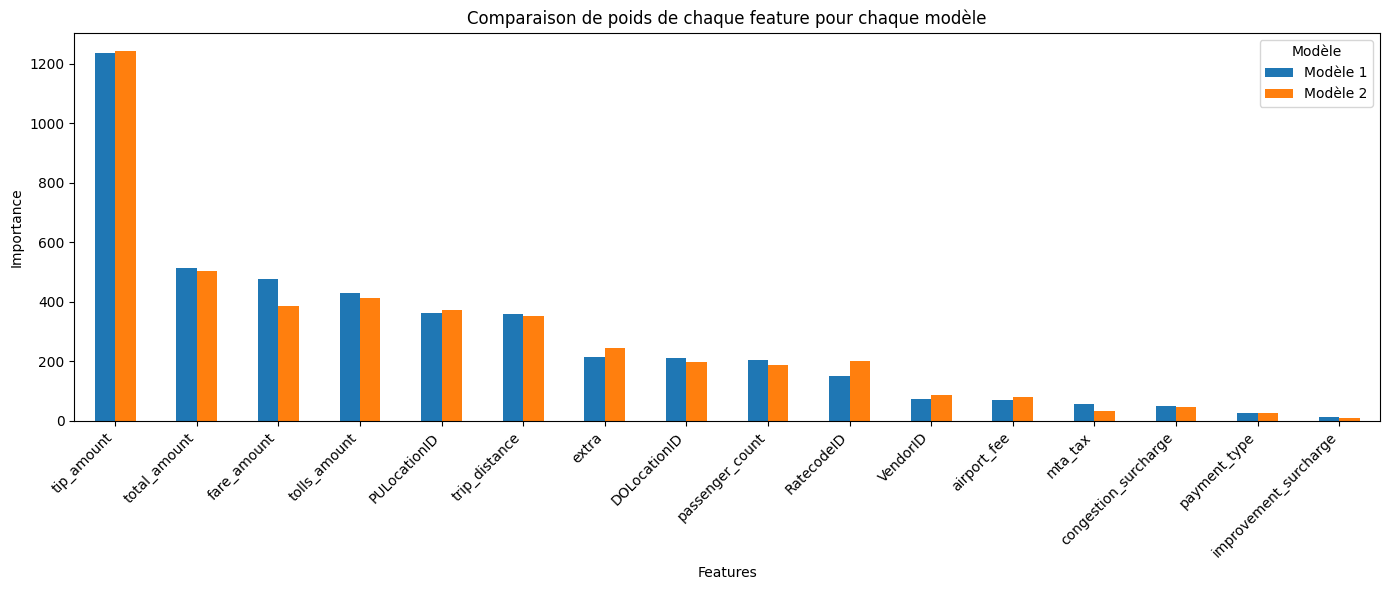

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

models = [model1, model2]
names = ['Modèle 1', 'Modèle 2']

def get_importance_df(model, name):

    booster = model.get_booster()
    imp = booster.get_score(importance_type='weight')
    df = pd.DataFrame({
        'Feature': list(imp.keys()),
        name: list(imp.values())
    })
    return df


dfs = [get_importance_df(m, n) for m, n in zip(models, names)]
merged = dfs[0]

for df in dfs[1:]:
    merged = merged.merge(df, on='Feature', how='outer').fillna(0)


merged = merged.set_index('Feature')
merged = merged.sort_values(by=names[0], ascending=False).head(30)

ax = merged.plot(
    kind='bar',
    figsize=(14, 6)
)

plt.title('Comparaison de poids de chaque feature pour chaque modèle')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()